<a href="https://colab.research.google.com/github/Lakshaykumarr28/stocks-price-predictor/blob/main/stocks_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning GitHub repository to load datasets.

In [ ]:
!git clone https://github.com/Lakshaykumarr28/stocks-price-predictor

Cloning into 'stocks-price-predictor'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 9), reused 12 (delta 3), pack-reused 0
Receiving objects: 100% (24/24), 494.84 KiB | 9.00 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Importing necessary libraries

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

## Predicting the values of stock prices using SVM models and comparing their results.

Dates-  [15, 16, 17, 18, 21, 22, 23, 24, 25]
Prices-  [306.140015, 300.200012, 293.049988, 279.029999, 283.450012, 292.549988, 288.5, 298.5, 286.130005]


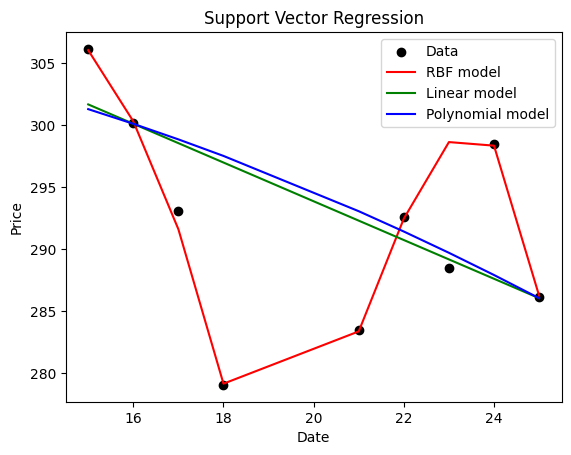


The stock open price for 29th Feb is: (251.25421844591037, 281.3400026666792, 279.96731905677666)
RBF kernel: $ 251.25421844591037
Linear kernel: $ 281.3400026666792
Polynomial kernel: $ 279.96731905677666


In [ ]:

dates = []
prices = []

def get_data(filename):
	with open(filename, 'r') as csvfile:
		csvFileReader = csv.reader(csvfile)
		next(csvFileReader)	# skipping column names
		for row in csvFileReader:
			dates.append(int(row[0].split('-')[2]))
			prices.append(float(row[1]))
	return

def predict_price(dates, prices, x):
	dates = np.reshape(dates,(len(dates), 1)) # converting to matrix of n X 1

	svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1) # defining the support vector regression models
	svr_lin = SVR(kernel= 'linear', C= 1e3, gamma = 'auto')
	svr_poly = SVR(kernel= 'poly', C= 1e3, degree= 2, gamma = 'auto')
	svr_rbf.fit(dates, prices) # fitting the data points in the models
	svr_lin.fit(dates, prices)
	svr_poly.fit(dates, prices)

	plt.scatter(dates, prices, color= 'black', label= 'Data') # plotting the initial datapoints
	plt.plot(dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
	plt.plot(dates,svr_lin.predict(dates), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
	plt.plot(dates,svr_poly.predict(dates), color= 'blue', label= 'Polynomial model') # plotting the line made by polynomial kernel
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.title('Support Vector Regression')
	plt.legend()
	plt.show()

	return svr_rbf.predict(np.array(x).reshape(-1,1))[0], svr_lin.predict(np.array(x).reshape(-1,1))[0], svr_poly.predict(np.array(x).reshape(-1,1))[0]

get_data('/content/stocks-price-predictor/stocks_csv_files/META_for svm.csv') # calling get_data method by passing the csv file to it
print("Dates- ", dates)
print("Prices- ", prices)

predicted_price = predict_price(dates, prices, 28)
print("\nThe stock open price for 29th Feb is:", predicted_price)
print("RBF kernel: $", str(predicted_price[0]))
print("Linear kernel: $", str(predicted_price[1]))
print("Polynomial kernel: $", str(predicted_price[2]))


# Creating a LSTM model for stock price prediction model.

Introducing datasets.

In [ ]:
adani_stocks = '/content/stocks-price-predictor/stocks_csv_files/Adani Enterprises Limited.csv'
Microsoft_stocks = '/content/stocks-price-predictor/stocks_csv_files/MSFT.csv'
Meta_stocks = '/content/stocks-price-predictor/stocks_csv_files/META.csv'
dataset = pd.read_csv(Meta_stocks)
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,338.299988,341.079987,337.190002,338.540009,338.540009,14537900
1,2022-01-04,339.950012,343.089996,331.869995,336.529999,336.529999,15998000
2,2022-01-05,333.019989,335.760010,323.839996,324.170013,324.170013,20564500
3,2022-01-06,322.820007,339.170013,322.720001,332.459991,332.459991,27962800
4,2022-01-07,332.739990,337.000000,328.880005,331.790009,331.790009,14722000
...,...,...,...,...,...,...,...
405,2023-08-15,306.140015,307.230011,300.029999,301.950012,301.950012,11623600
406,2023-08-16,300.200012,301.079987,294.279999,294.290009,294.290009,18547700
407,2023-08-17,293.049988,296.049988,284.950012,285.089996,285.089996,23950100
408,2023-08-18,279.029999,285.690002,274.380005,283.250000,283.250000,34061200


## Creating DataFrame and preprocessing the data.

In [ ]:
df = dataset[['Date', 'Close']]

df

,Date,Close
0,2022-01-03,338.540009
1,2022-01-04,336.529999
2,2022-01-05,324.170013
3,2022-01-06,332.459991
4,2022-01-07,331.790009
...,...,...
405,2023-08-15,301.950012
406,2023-08-16,294.290009
407,2023-08-17,285.089996
408,2023-08-18,283.250000


Making a function to change date type from 'object' to 'datetime'.

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

Applying the function on date column

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-7-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0     2022-01-03
1     2022-01-04
2     2022-01-05
3     2022-01-06
4     2022-01-07
         ...    
405   2023-08-15
406   2023-08-16
407   2023-08-17
408   2023-08-18
409   2023-08-21
Name: Date, Length: 410, dtype: datetime64[ns]

Changing the index to date.

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2022-01-03,338.540009
2022-01-04,336.529999
2022-01-05,324.170013
2022-01-06,332.459991
2022-01-07,331.790009
...,...
2023-08-15,301.950012
2023-08-16,294.290009
2023-08-17,285.089996


Plotting the value of stocks.

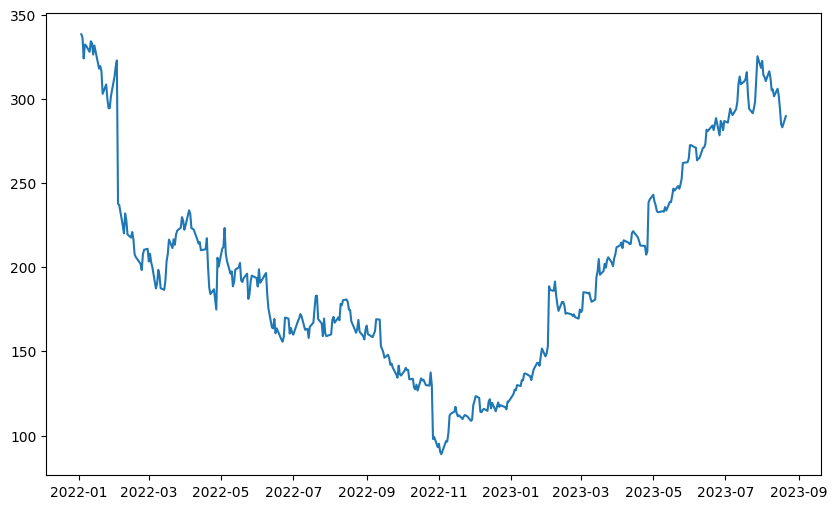

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.plot(df.index, df['Close'])

Creating a function to make windowed df that shows the relation between target date's stock's prices and stock prices three days before.

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date


    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

#use end date for MSFT : 2023-08-21
#use end date for adani stocks : 2023-08-22
windowed_df = df_to_windowed_df(df,
                                '2022-01-06',
                                '2023-08-21',
                                n=3)

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-01-06,338.540009,336.529999,324.170013,332.459991
1,2022-01-07,336.529999,324.170013,332.459991,331.790009
2,2022-01-10,324.170013,332.459991,331.790009,328.070007
3,2022-01-11,332.459991,331.790009,328.070007,334.369995
4,2022-01-12,331.790009,328.070007,334.369995,333.260010
...,...,...,...,...,...
402,2023-08-15,305.739990,301.640015,306.190002,301.950012
403,2023-08-16,301.640015,306.190002,301.950012,294.290009
404,2023-08-17,306.190002,301.950012,294.290009,285.089996
405,2023-08-18,301.950012,294.290009,285.089996,283.250000


Creating a function to get date, X, and Y values from windowed dataframe.

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((407,), (407, 3, 1), (407,))

# Splitting the dataset in training, validation and testing dataset and plotting it for visualisation.

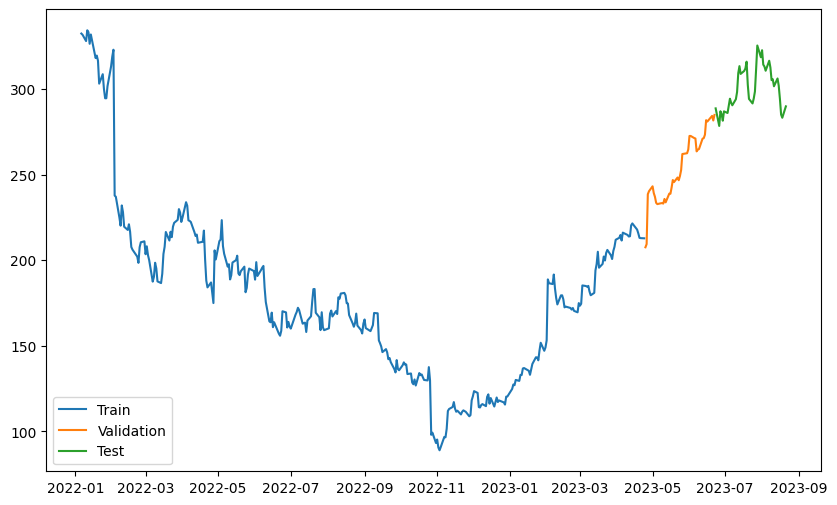

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize = (10,6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Creating a LSTM neural network for price prediction.

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
11/11 [==============================] - 3s 48ms/step - loss: 33922.9531 - accuracy: 0.0000e+00 - val_loss: 62877.2695 - val_accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 32818.0078 - accuracy: 0.0000e+00 - val_loss: 60819.7812 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 30913.8711 - accuracy: 0.0000e+00 - val_loss: 57115.5234 - val_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 27189.2773 - accuracy: 0.0000e+00 - val_loss: 49178.0977 - val_accuracy: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 20266.5977 - accuracy: 0.0000e+00 - val_loss: 36159.5195 - val_accuracy: 0.0000e+00
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 11012.4414 - accuracy: 0.0000e+00 - val_loss: 18216.4082 - val_accuracy: 0.0000e+00
Epoch 7/100
11/11 [==============================] - 0s 6

Plotting the model.

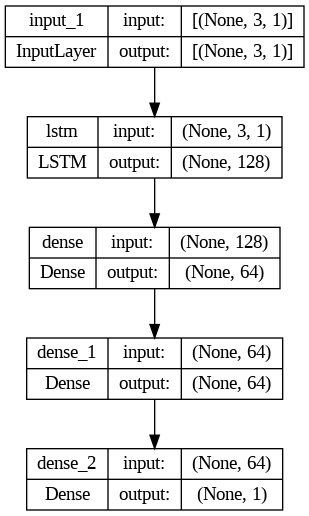

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Predicting values using model and plotting results.

11/11 [==============================] - 0s 2ms/step


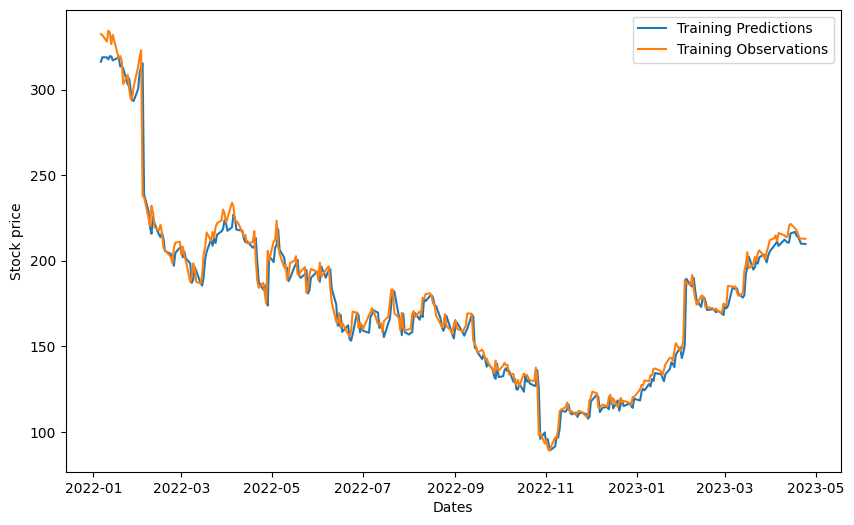

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize = (10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xlabel('Dates')
plt.ylabel('Stock price')
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 12ms/step


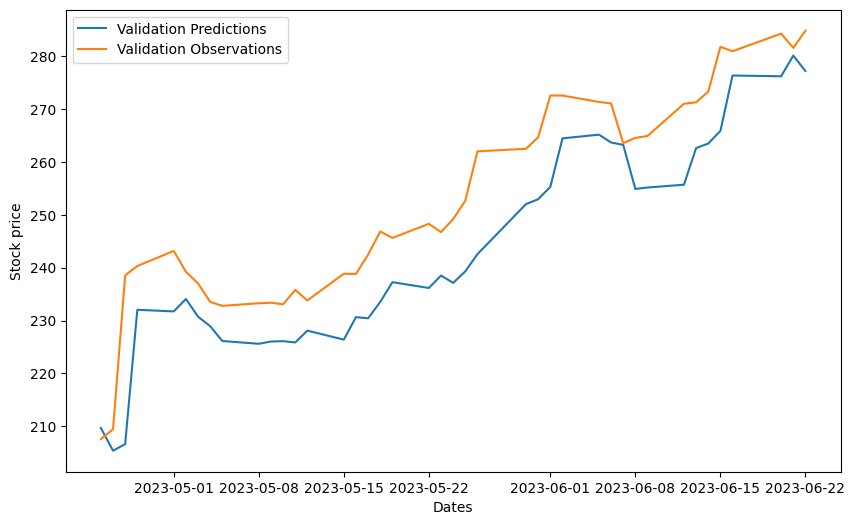

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize = (10,6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xlabel('Dates')
plt.ylabel('Stock price')
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 4ms/step


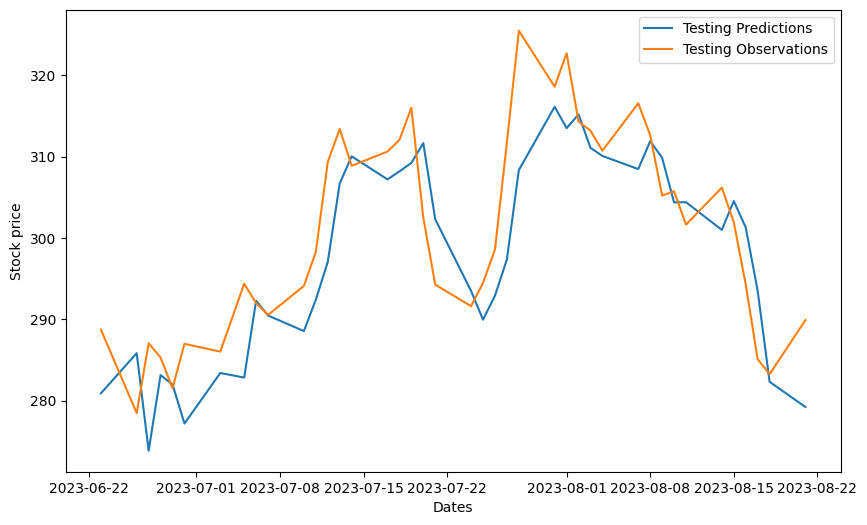

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize = (10,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xlabel('Dates')
plt.ylabel('Stock price')
plt.legend(['Testing Predictions', 'Testing Observations'])

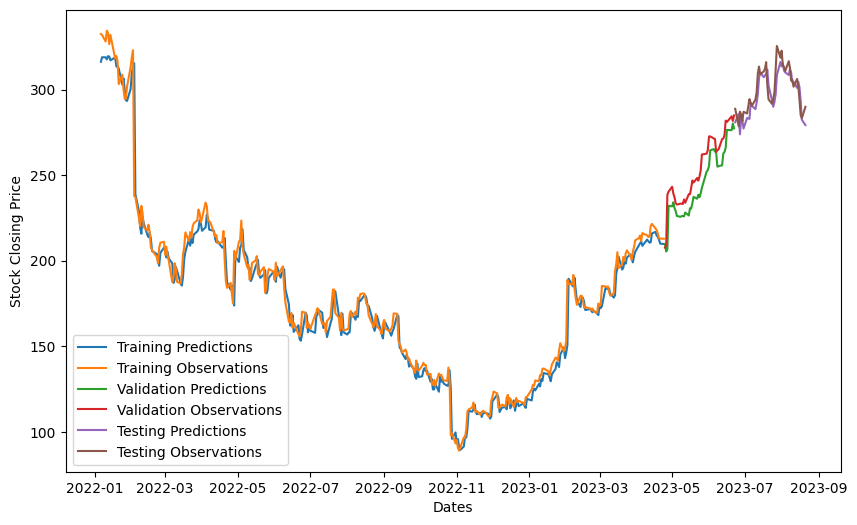

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xlabel('Dates')
plt.ylabel('Stock Closing Price')
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])